In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import tensorflow as tf
import tensorflow_probability as tfp

sys.path.append(os.path.abspath(os.path.join('../BayesFlow')))

from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.networks import InvertibleNetwork, InvariantNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.models import GenerativeModel
from bayesflow.diagnostics import true_vs_estimated
from bayesflow.exceptions import ConfigurationError

from meta_aux_classes import *

In [2]:
class GaussianPrior:
    def __init__(self, D, mu_mean=0, mu_scale=1):
        self.D = D
        self.mu_mean = mu_mean
        self.mu_scale = mu_scale
    
    def __call__(self, n_sim):
        theta = np.random.default_rng().normal(self.mu_mean, self.mu_scale, size=(n_sim, self.D))
        return theta

class GaussianSimulator:
    def __init__(self, D, s = None):
        
        # Default: Unit variance
        if s is None:
            sigma = np.eye(D)
            
        # Unit variance with factor s
        elif isinstance(s, (int, float)):
            sigma = np.eye(D) * s
            
            
        # s is list or np.array --> Either custom diagonal or full
        elif isinstance(s, (list, np.ndarray)):
            # cast any list-like input to float np.array 
            if isinstance(s, list):
                s = np.array(s)   
            s = s.astype(float)
            
            # Diagonal covariance matrix with different diagonal entries (from s)
            if s.ndim == 1:
                assert len(s) == D, "Must provide D entries in diagonal s!"
                sigma = np.diag(s)
                
            # Full covariance matrix    
            elif s.ndim == 2:
                assert s.shape[0] == D and s.shape[1] == D, "Must provide DxD matrix!"
                try: 
                    _ = np.linalg.cholesky(s)
                except:
                    raise ConfigurationError("Covariance Matrix must be positive semidefinite!")
                
                sigma = s
            
        self.D = D    
        self.sigma = sigma
    
    def __call__(self, theta, n_obs):
        n_sim, D = theta.shape
        assert D == self.D
        
        tril = tf.linalg.cholesky(np.stack([self.sigma] * n_sim))   # tf requires cholesky decomposed sigma
        
        mvn = tfp.distributions.MultivariateNormalTriL(loc=theta, scale_tril=tril)

        sim_data = mvn.sample(n_obs)
        sim_data = np.array(sim_data)
        sim_data = np.transpose(sim_data, (1, 0, 2))
        return sim_data
    
D = 3
prior = GaussianPrior(D=D)
simulator = GaussianSimulator(D=D)

In [3]:
D = 3
prior = GaussianPrior(D=D)
simulator = GaussianSimulator(D=D, s = 2.5)

theta = prior(4)
print(simulator.sigma)
simulator(theta, 5)

[[2.5 0.  0. ]
 [0.  2.5 0. ]
 [0.  0.  2.5]]


array([[[ 1.36092008, -0.9755342 , -0.29523161],
        [ 3.97017666, -0.94996973, -0.37070383],
        [-1.59391414, -0.23879501,  5.99558804],
        [ 2.37575686, -0.48011785,  1.40944338],
        [ 1.15262607,  0.70490906,  0.32798431]],

       [[-1.17478249,  0.452643  ,  0.4939862 ],
        [ 0.72163788,  2.03601526,  2.12769408],
        [-0.28323225,  0.38682596,  2.51251709],
        [ 0.95524339,  0.63448735,  0.19932532],
        [-0.47327153, -1.31074622,  0.67217092]],

       [[-2.75395044,  0.1656947 ,  2.04830395],
        [-0.21760025,  2.97754051,  1.21837227],
        [ 1.54371862,  2.50996635,  0.75991311],
        [-2.38954358,  1.51226349,  1.28264072],
        [ 0.04773535,  5.91105489,  0.71375695]],

       [[ 3.1276667 , -1.57871932, -1.49521558],
        [ 2.92389539,  1.45131608, -2.4652216 ],
        [ 4.11215838, -2.72163047, -0.57560379],
        [ 1.52419256,  2.36109212, -2.73731699],
        [ 1.4789368 , -0.14496875,  1.26783949]]])

In [4]:
D = 3
prior = GaussianPrior(D=D)
simulator = GaussianSimulator(D=D, s = [1,2,3])

theta = prior(4)
print(simulator.sigma)
simulator(theta, 5)

[[1. 0. 0.]
 [0. 2. 0.]
 [0. 0. 3.]]


array([[[-1.28304374e-01, -1.21519922e+00, -1.26820043e-01],
        [-8.16788545e-01,  2.77822051e+00,  1.15812525e+00],
        [ 1.68838882e+00, -5.33652972e-01, -1.05553793e+00],
        [ 1.15972590e+00,  2.01960487e+00,  1.74496862e+00],
        [ 5.65669211e-02,  1.68766205e+00,  5.17043464e-01]],

       [[ 3.19533223e-03, -2.12646368e+00,  3.35216477e+00],
        [-1.24687020e+00, -1.23116014e+00, -1.73063399e+00],
        [ 3.50920760e-02, -8.07477085e-01, -2.57684323e-01],
        [-2.68947777e-01, -7.24003103e-02,  2.87339851e+00],
        [ 3.32183345e-01, -1.47071168e-01, -1.91919250e+00]],

       [[ 1.49704017e+00,  2.06029276e-01, -2.07456791e+00],
        [-7.97676629e-01,  3.86162518e-01, -2.54346700e+00],
        [ 1.05748241e+00,  2.06326739e+00, -3.10431505e-01],
        [ 8.18689301e-01, -7.19329054e-01,  8.24613331e-01],
        [ 1.80013959e-01,  2.75468642e+00, -8.50030199e-01]],

       [[ 3.57060188e-01,  4.33045438e-01, -1.67793490e+00],
        [-6.768329

In [5]:
D = 3
prior = GaussianPrior(D=D)
simulator = GaussianSimulator(D=D, s = np.array([1,2,3]))

theta = prior(4)
print(simulator.sigma)
simulator(theta, 5)

[[1. 0. 0.]
 [0. 2. 0.]
 [0. 0. 3.]]


array([[[-1.28913212, -1.78432201,  1.30656703],
        [-1.26928752,  2.70516887,  1.35644044],
        [-0.59421835,  1.82873925,  0.06677453],
        [-0.63092085, -0.2768835 , -2.91529839],
        [ 0.03190156,  0.63957878, -1.26975719]],

       [[ 1.05696761, -0.05229697,  2.72728182],
        [ 0.05203423,  4.26861642, -1.57344921],
        [ 0.32072312,  0.48155036,  0.03014649],
        [ 0.38361016,  2.64639931, -0.57370299],
        [-1.43472602,  1.22630999,  0.79018169]],

       [[ 1.03945174,  0.41758101, -3.01161901],
        [ 0.88625923, -3.01218135, -2.73535391],
        [-0.16277326,  0.88121816, -2.52646382],
        [-0.12522849,  0.21209656, -2.12277436],
        [-1.47039617, -0.40756803, -1.74112221]],

       [[-0.96771047,  0.279577  ,  1.10863283],
        [-0.29725   ,  1.92952953, -4.23202875],
        [ 0.10338178,  4.45023883,  1.34310909],
        [ 1.15136531, -0.140936  , -2.14175463],
        [-0.44930414,  2.17961625, -2.01619355]]])

In [6]:
D = 3
prior = GaussianPrior(D=D)
simulator = GaussianSimulator(D=D, s = np.array([[1,0,0],[0,1,0],[0,0,1]]))

theta = prior(4)
print(simulator.sigma)
simulator(theta, 5)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


array([[[ 0.8784552 ,  1.56934423,  0.75418001],
        [ 0.91830396,  0.01552951,  2.35391892],
        [ 0.50883096, -1.25014577,  1.54431997],
        [-0.52263589, -0.8145395 ,  1.49625268],
        [ 3.49023896, -1.33204113,  0.04549575]],

       [[ 1.21883213,  1.95235488,  0.90404484],
        [ 0.57841977,  2.28610659,  0.80472272],
        [-0.09943689,  2.17681017,  0.68670696],
        [ 0.81813044,  0.84582771,  1.96635328],
        [ 1.00329237,  1.08023098,  1.42781448]],

       [[ 2.77832849, -0.60135744, -0.81360086],
        [ 1.73892842,  0.50502383,  0.33391595],
        [ 2.08185992, -1.49664131, -0.0460224 ],
        [ 0.6177194 , -1.32440065,  0.55402669],
        [ 2.47279905, -1.41591365,  0.25637275]],

       [[ 1.25758229,  1.84431926,  2.08801433],
        [-0.12263001,  0.93714831, -0.63562006],
        [ 1.07797152,  2.66335882,  0.13071916],
        [ 0.94305484,  1.69224345,  1.72995519],
        [-1.43491227,  0.83569245,  0.93667751]]])

In [7]:
D = 5 

#########

prior = GaussianPrior(D=D)
simulator = GaussianSimulator(D=D)
generative_model = GenerativeModel(prior, simulator)

#########

summary_meta = {
    'n_dense_s1': 2,
    'n_dense_s2': 2,
    'n_dense_s3': 2,
    'n_equiv':    1,
    'dense_s1_args': {'activation': 'relu', 'units': 32},
    'dense_s2_args': {'activation': 'relu', 'units': 32},
    'dense_s3_args': {'activation': 'relu', 'units': 32},
}

class BottleneckSummaryNet(tf.keras.Model):
    def __init__(self, inv_meta={}, n_out=10, activation_out=None):
        super(BottleneckSummaryNet, self).__init__()

        self.invariant_net = InvariantNetwork(inv_meta)
        self.out_layer = tf.keras.layers.Dense(n_out, activation=activation_out)
    
    def __call__(self, x):
        out_inv = self.invariant_net(x)
        out = self.out_layer(out_inv)
        return out


summary_net = BottleneckSummaryNet(inv_meta=summary_meta, 
                                   n_out=D*2,  # one mean and variance per dim
                                   activation_out=None  # linear
                                  )


inference_meta = {
    'n_coupling_layers': 2,
    's_args': {
        'units': [32, 32, 32],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [32, 32, 32],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': D,
    'alpha': 1.9,
    'permute': True
}

inference_net = InvertibleNetwork({'n_params': D})

amortizer = SingleModelAmortizer(inference_net, summary_net)

In [8]:
trainer = ParameterEstimationTrainer(amortizer,
                      generative_model,
                      learning_rate=0.0001,
                      checkpoint_path='export_ckpt/'
                     )

Initializing networks from scratch.


In [11]:
losses = trainer.train_rounds(epochs=10, rounds=5, sim_per_round=20000, batch_size=1024, n_obs=100)

Simulating initial 20000 data sets...
Converting 20000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/20 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/20 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/20 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/20 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/20 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/20 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/20 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/20 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/20 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/20 [00:00<?, ?it/s]

Simulating new 20000 data sets and appending to previous...
New total number of simulated data sets: 40000
Converting 40000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/40 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/40 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/40 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/40 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/40 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/40 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/40 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/40 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/40 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/40 [00:00<?, ?it/s]

Simulating new 20000 data sets and appending to previous...
New total number of simulated data sets: 60000
Converting 60000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/59 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/59 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/59 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/59 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/59 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/59 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/59 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/59 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/59 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/59 [00:00<?, ?it/s]

Simulating new 20000 data sets and appending to previous...
New total number of simulated data sets: 80000
Converting 80000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Simulating new 20000 data sets and appending to previous...
New total number of simulated data sets: 100000
Converting 100000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/98 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/98 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/98 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/98 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/98 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/98 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/98 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/98 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/98 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/98 [00:00<?, ?it/s]

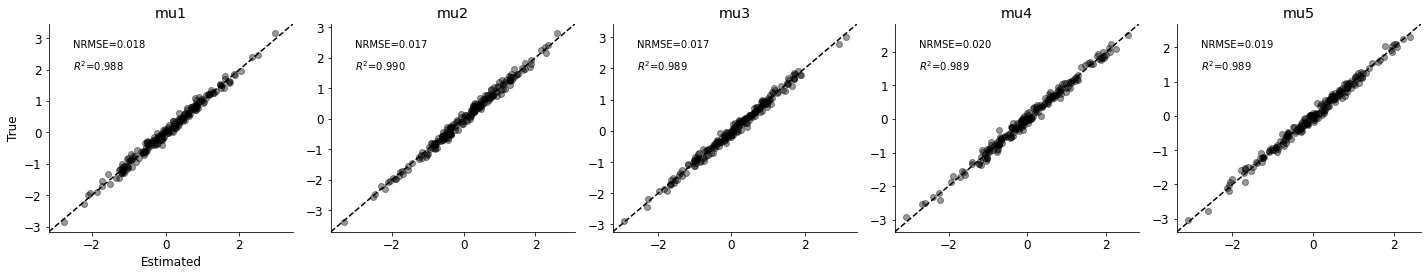

In [13]:
# Validate (quick and dirty)
p, x = trainer._forward_inference(200, 100)
param_samples = trainer.network.sample(x, n_samples=200)
param_means = param_samples.mean(axis=0)
true_vs_estimated(p, param_means, ['mu{}'.format(i) for i in range(1, 5+1)], figsize=(20,4))

In [14]:
trainer.network.summary_net(x).shape

TensorShape([200, 10])

In [15]:
trainer.manager.save()

'export_ckpt/ckpt-101'